# Задача
одна из проблем, которую мы видим при обращении в саппорт - в разрезе разных категорий обращения необходимо смотреть в разные сервисы и собирать дополнительную информацию. На это уходит много времени. на одно обращение уходит в среднем 2 минуты поиска дополнительной информации. Стоимость часа работы сотрудника 6$.

Давайте поможем и оптимизируем время и деньги компании - сделаем модель,которая в зависимости от текста будет определять категорию обращения автоматически.

Тогда мы сможем сразу подготавливать информацию для наших операторов в течение 5 секунд (сбор и передача на фронт)

Нужно сделать модель многоклассовой классификации определения категории обращения

# Загрузка данных

In [319]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression


import datetime
import requests
import collections as co
import string
import re

from nltk.tokenize import RegexpTokenizer
from sumy.utils import get_stop_words as gsw1
from stop_words import get_stop_words as gsw2


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from imblearn.over_sampling import RandomOverSampler

import pickle 

Загружаю только часть данных для более быстрой обработки

In [322]:
df = pd.read_csv('./data/3categories_50.csv')[:10000]
df.shape

(10000, 3)

In [323]:
df.head(2)

,channel,category,message
0,chat,afs,\nChat transcript:\nVisitor: I am attempting t...
1,chat,other,\nChat transcript:\nVisitor: Hi. For some reas...


In [328]:
#смотрим распределение по категориям
df.groupby("category").count().message

category
afs      7070
other    1669
ps       1261
Name: message, dtype: int64

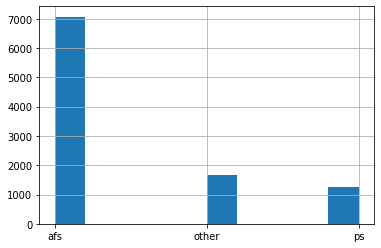

In [324]:
df['category'].hist()

# Производим очистку данных

In [325]:
df['message'] = df['message'].str.replace('\[.*\]', '', regex=True)
df['message'] = df['message'].str.replace("\!", '', regex=True)
df['message'] = df['message'].str.replace("\'", '', regex=True)
df['message'] = df['message'].str.replace("\s+", ' ', regex=True)
df['message'] = df['message'].str.replace("[^A-Za-z0-9^,!.\/'+-=]", ' ', regex=True)
df['message'] = df['message'].str.replace(r"http\S+", "")
df['message'] = df['message'].str.replace(r"http", "")
df['message'] = df['message'].str.replace(r"@\S+", "")
df['message'] = df['message'].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
df['message'] = df['message'].str.replace(r"@", "at")
df['message'] = df['message'].str.replace('\n', " ")
df['message'] = df['message'].str.lower()

In [326]:
#уберем шум
df.dropna(inplace = True)
df.shape

(10000, 3)

In [327]:
df.head()

,channel,category,message
0,chat,afs,chat transcript visitor i am attempting to ...
1,chat,other,chat transcript visitor hi for some reason...
2,chat,afs,"chat transcript visitor , ..."
3,chat,afs,chat transcript visitor no puedo hacer la r...
4,chat,afs,chat transcript visitor hi im trying to buy...


In [330]:
#делим на токены


tokenizer = RegexpTokenizer(r'\w+')

df["tokens"] = df["message"].apply(tokenizer.tokenize)

In [331]:
df.head()

,channel,category,message,tokens
0,chat,afs,chat transcript visitor i am attempting to ...,"[chat, transcript, visitor, i, am, attempting,..."
1,chat,other,chat transcript visitor hi for some reason...,"[chat, transcript, visitor, hi, for, some, rea..."
2,chat,afs,"chat transcript visitor , ...","[chat, transcript, visitor, faceit, andrew, vi..."
3,chat,afs,chat transcript visitor no puedo hacer la r...,"[chat, transcript, visitor, no, puedo, hacer, ..."
4,chat,afs,chat transcript visitor hi im trying to buy...,"[chat, transcript, visitor, hi, im, trying, to..."


In [332]:
#Оцениваем объем работы. Фиксируем длину обращений

all_words = [word for tokens in df["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

1346978 words total, with a vocabulary size of 30860
Max sentence length is 6623


In [333]:
#Сопоставляем длину обращений и сами сообщения
df['sentence_lengths'] = sentence_lengths

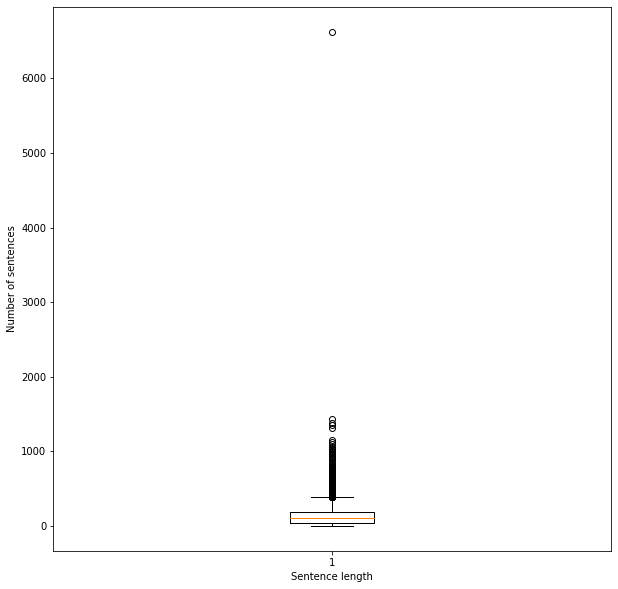

In [334]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.boxplot(df.sentence_lengths)
plt.show()

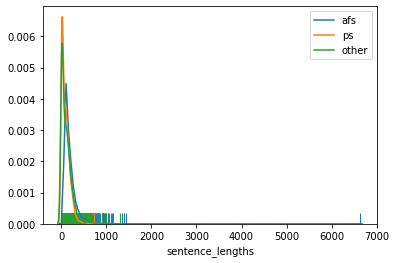

In [335]:
sns.distplot(df.sentence_lengths[df.category == 'afs'], label='afs', hist=False, rug=True)
sns.distplot(df.sentence_lengths[df.category == 'ps'], label='ps', hist=False, rug=True)
sns.distplot(df.sentence_lengths[df.category == 'other'], label='other', hist=False, rug=True)

Видно, что сообщения со словами больше, чем 400 нетипичны для обращений службы поддержки. Удаляем их, чтобы не мешались.

In [336]:
df = df.drop(df[df.sentence_lengths > 400].index)

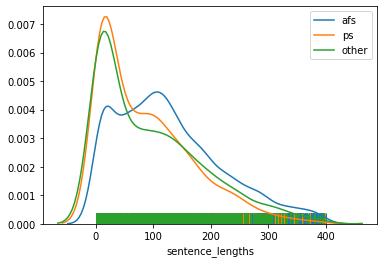

In [337]:
sns.distplot(df.sentence_lengths[df.category == 'afs'], label='afs', hist=False, rug=True)
sns.distplot(df.sentence_lengths[df.category == 'ps'], label='ps', hist=False, rug=True)
sns.distplot(df.sentence_lengths[df.category == 'other'], label='other', hist=False, rug=True)

In [338]:
#обозначаем лейблы
df['category_label'] = df.category.replace(['other', 'afs', 'ps'], [0,1,2])

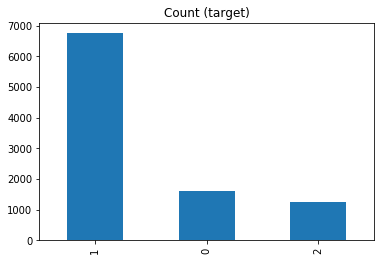

In [339]:
df['category_label'].value_counts().plot(kind='bar', title='Count (target)');

rate target detect fight in game 1.0


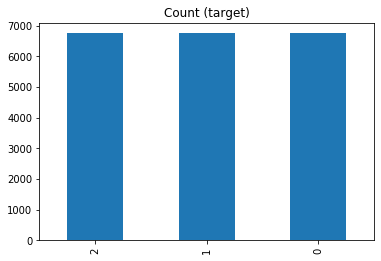

In [340]:
#оверсемплинг
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(df, df['category_label'])

print(f'rate target detect fight in game {sum(y_ros) / X_ros.shape[0]}')

y_ros.value_counts().plot(kind='bar', title='Count (target)');

In [341]:
X_ros.head()

,channel,category,message,tokens,sentence_lengths,category_label
0,chat,afs,chat transcript visitor i am attempting to ...,"[chat, transcript, visitor, i, am, attempting,...",56,1
1,chat,other,chat transcript visitor hi for some reason...,"[chat, transcript, visitor, hi, for, some, rea...",115,0
2,chat,afs,"chat transcript visitor , ...","[chat, transcript, visitor, faceit, andrew, vi...",36,1
3,chat,afs,chat transcript visitor no puedo hacer la r...,"[chat, transcript, visitor, no, puedo, hacer, ...",159,1
4,chat,afs,chat transcript visitor hi im trying to buy...,"[chat, transcript, visitor, hi, im, trying, to...",106,1


In [342]:
#Использую самый простой метод count_vectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = X_ros["message"].tolist()
list_labels = X_ros["category_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [343]:
#Смотрим размерность
X_train_counts

<16197x24150 sparse matrix of type '<class 'numpy.int64'>'
	with 986568 stored elements in Compressed Sparse Row format>

In [344]:
X_test_counts

<4050x24150 sparse matrix of type '<class 'numpy.int64'>'
	with 246644 stored elements in Compressed Sparse Row format>

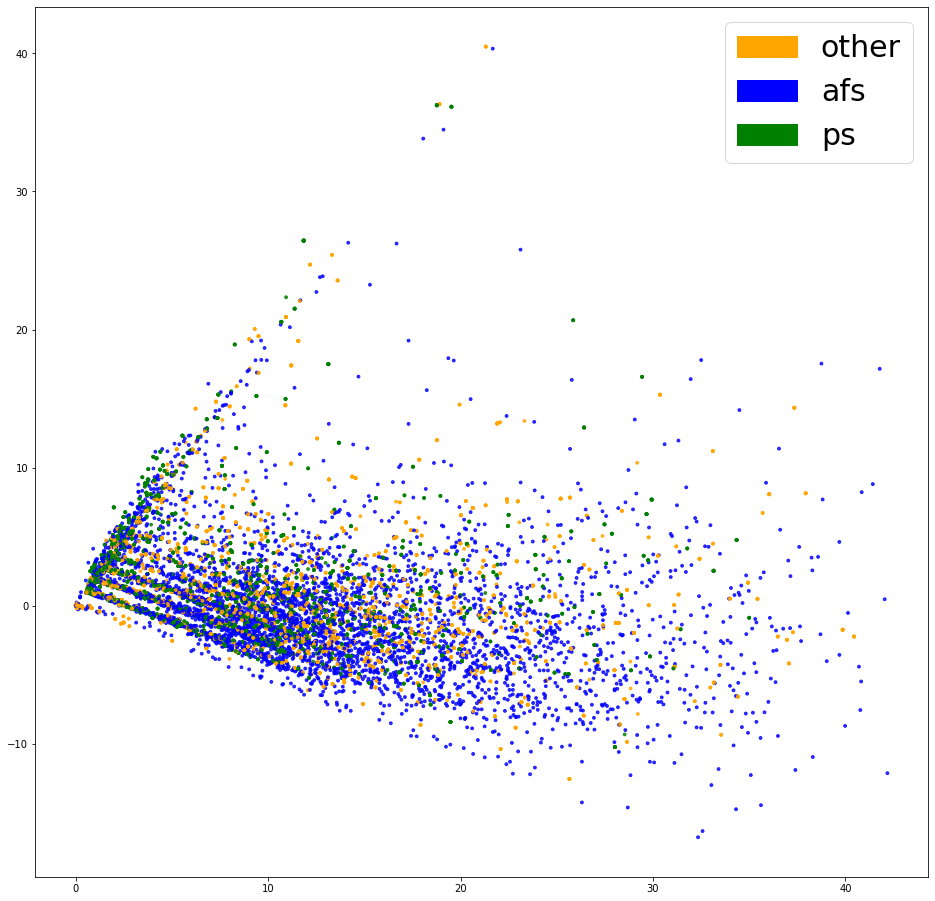

In [346]:
#Воспользуемся методом главных компонент и посмотрим на распределение данных
def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','green']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='other')
            blue_patch = mpatches.Patch(color='blue', label='afs')
            green_patch = mpatches.Patch(color='green', label='ps')
            plt.legend(handles=[red_patch, blue_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

Выглядит не очень хорошо, но посмотрим, что покажет

In [347]:
#Воспользуемся логстической регрессией для создания модели



clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [348]:
#Посмотрим метрики полученной модели


def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.908, precision = 0.916, recall = 0.908, f1 = 0.908


In [350]:
#Функция для построения матрицы ошибок
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] < thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

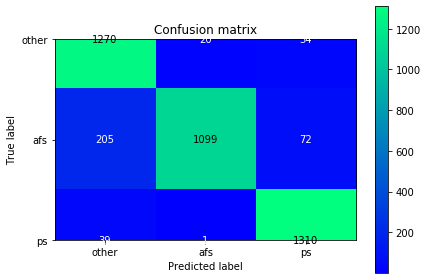

[[1270   20   34]
 [ 205 1099   72]
 [  39    1 1310]]


In [351]:
#Построим ее
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure()
plot = plot_confusion_matrix(cm, classes=['other','afs','ps'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [352]:
#Сохраняем

pickle.dump(count_vectorizer,open("feature.pkl","wb"))
pickle.dump(clf,open("clf.sav","wb"))

Модель можно улучшить следующим образом:
1. Произвести стемминг и оставить в датасете предложения со стемами
2. Провести анализ слов, которые часто встречаются во всех трех категориях и удалить их (я делал такую вещь в задание по бинарной классификации)
3. Использовать TF-IDF
4. Использовать Word2Vec
5. В качестве модели можно попробовать использовать нейронные сети